# Sub-graphs

A sub-graph is a graph that is used as a node in another graph. This is particulary useful for multi-agent systems, with team of agents that each have their own graph and state.

Sub-graphs can communicate with the parent graph, but if they use different states, we need to handle state transformation. 

In this notebook we create a recipe generation graph, with two subgraphs, one is used to generate the recipe and steps, and the other one to generate nutritional informations.

In [1]:
# Import libraries
import sys, os

In [2]:
# Import settings and sensitive variables from config
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from codes.config.config import config

2025-09-10 01:13:53,801 - root - INFO - Configuration loaded for environment: development


In [30]:
# Import libraries
from operator import add
from pprint import pprint
from typing_extensions import TypedDict
from IPython.display import Image, display
from typing import List, Dict, Optional, Annotated

from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage, AnyMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [33]:
# Create sub-graph states
class RecipeCard(TypedDict):
    dish_name: str
    ingredients: List[str]
    steps: List[str]

class NutritionalInfo(TypedDict):
    calories: int
    macros: Dict[str, int]


# Create parent graph state
class EntryGraph(TypedDict):
    messages: Annotated[list[AnyMessage], add]
    diet_type: str
    nutritional_goal: str
    recipe: Optional[RecipeCard]
    nutritional_info: Optional[NutritionalInfo]


2025-09-10 15:58:34,437 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-10 15:58:34,695 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCW5hbWUobmFtZSkKCWluZ3JlZGllbnRzKGluZ3JlZGllbnRzKQoJc3RlcHMoc3RlcHMpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBuYW1lOwoJaW5ncmVkaWVudHMgLS0+IHN0ZXBzOwoJbmFtZSAtLT4gaW5ncmVkaWVudHM7CglzdGVwcyAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 10804


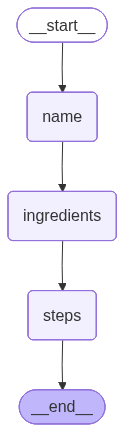

In [38]:
# Recipe sub-graph implementation
def generate_recipe_name(state: RecipeCard):
    # Extract dish name from existing ingredients or create default
    dish_name = "Healthy Pasta Bowl"
    return {"dish_name": dish_name}

def generate_ingredients(state: RecipeCard):
    # Generate ingredients based on the dish
    ingredients = [
        "200g whole wheat pasta",
        "2 tbsp olive oil",
        "3 cloves garlic, minced",
        "400g canned tomatoes",
        "1/4 cup fresh basil",
        "50g parmesan cheese"
    ]
    return {"ingredients": ingredients}

def generate_cooking_steps(state: RecipeCard):
    steps = [
        "Boil salted water in a large pot",
        "Cook pasta according to package instructions until al dente",
        "Heat olive oil in a pan and sauté minced garlic",
        "Add canned tomatoes and simmer for 10 minutes",
        "Drain pasta and combine with sauce",
        "Garnish with fresh basil and parmesan cheese"
    ]
    return {"steps": steps}

# CREATE RECIPE SUB-GRAPH
recipe_subgraph_builder = StateGraph(RecipeCard)
recipe_subgraph_builder.add_node("name", generate_recipe_name)
recipe_subgraph_builder.add_node("ingredients", generate_ingredients)
recipe_subgraph_builder.add_node("steps", generate_cooking_steps)

recipe_subgraph_builder.add_edge(START, "name")
recipe_subgraph_builder.add_edge("name", "ingredients")
recipe_subgraph_builder.add_edge("ingredients", "steps")
recipe_subgraph_builder.add_edge("steps", END)

recipe_subgraph = recipe_subgraph_builder.compile()
display(Image(recipe_subgraph.get_graph(xray=1).draw_mermaid_png()))

2025-09-10 15:58:12,414 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-10 15:58:13,135 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWNhbG9yaWVzKGNhbG9yaWVzKQoJbWFjcm9zKG1hY3JvcykKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IGNhbG9yaWVzOwoJY2Fsb3JpZXMgLS0+IG1hY3JvczsKCW1hY3JvcyAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 8451


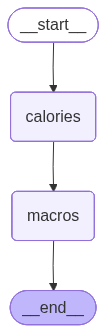

In [36]:
# Nutritional info node implementation
def calculate_calories(state: NutritionalInfo):
    # Simple calorie calculation (in real app, you'd use nutrition API)
    calories = 520  # Estimated for the pasta dish
    return {"calories": calories}

def calculate_macros(state: NutritionalInfo):
    calories = state.get("calories", 520)
    # Calculate macros based on calories (simplified)
    macros = {
        "protein": int(calories * 0.15 / 4),  # 15% protein, 4 cal/g
        "carbs": int(calories * 0.60 / 4),    # 60% carbs, 4 cal/g
        "fat": int(calories * 0.25 / 9)       # 25% fat, 9 cal/g
    }
    return {"macros": macros}

# CREATE NUTRITIONAL SUB-GRAPH
nutrition_subgraph_builder = StateGraph(NutritionalInfo)
nutrition_subgraph_builder.add_node("calories", calculate_calories)
nutrition_subgraph_builder.add_node("macros", calculate_macros)

nutrition_subgraph_builder.add_edge(START, "calories")
nutrition_subgraph_builder.add_edge("calories", "macros")
nutrition_subgraph_builder.add_edge("macros", END)

nutrition_subgraph = nutrition_subgraph_builder.compile()
display(Image(nutrition_subgraph.get_graph(xray=1).draw_mermaid_png()))

2025-09-10 16:01:10,367 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): mermaid.ink:443
2025-09-10 16:01:11,155 - urllib3.connectionpool - DEBUG - https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWV4dHJhY3RfcHJlZmVyZW5jZXMoZXh0cmFjdF9wcmVmZXJlbmNlcykKCWZpbmFsX3Jlc3BvbnNlKGZpbmFsX3Jlc3BvbnNlKQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCV9fc3RhcnRfXyAtLT4gZXh0cmFjdF9wcmVmZXJlbmNlczsKCWV4dHJhY3RfcHJlZmVyZW5jZXMgLS0+IG51dHJpdGlvbl9hZ2VudF9jYWxvcmllczsKCWV4dHJhY3RfcHJlZmVyZW5jZXMgLS0+IHJlY2lwZV9hZ2VudF9uYW1lOwoJbnV0cml0aW9uX2FnZW50X21hY3JvcyAtLT4gZmluYWxfcmVzcG9uc2U7CglyZWNpcGVfYWdlbnRfc3RlcHMgLS0+IGZpbmFsX3Jlc3BvbnNlOwoJZmluYWxfcmVzcG9uc2UgLS0+IF9fZW5kX187CglzdWJncmFwaCByZWNpcGVfYWdlbnQKCXJlY2lwZV9hZ2VudF9uYW1lKG5hbWUpCglyZWNpcGVfYWdlbnRfaW5ncmVkaWVudHMoaW5ncmVkaWVudHMpCglyZWNpcGVfYWdlbnRfc3RlcHMoc3RlcHMpCglyZWNpcGVfYWdlbnRfaW5ncmVkaWVudHMgLS0+IHJlY2lwZ

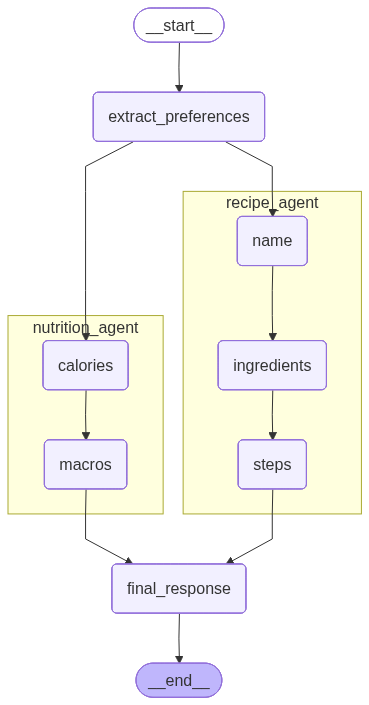

In [40]:
# PARENT GRAPH NODES (with state transformation)
def extract_user_preferences(state: EntryGraph):
    messages = state.get("messages", [])
    if messages:
        last_message = messages[-1].content if hasattr(messages[-1], 'content') else ""
        # Simple extraction (in real app, you'd use LLM)
        diet_type = "Mediterranean" if "healthy" in last_message.lower() else "Standard"
        nutritional_goal = "weight_maintenance"
    else:
        diet_type = "Standard"
        nutritional_goal = "weight_maintenance"
    
    return {
        "diet_type": diet_type,
        "nutritional_goal": nutritional_goal
    }


def invoke_recipe_subgraph(state: EntryGraph):
    """Transform parent state to recipe state, invoke subgraph, transform back"""
    
    # Create input for recipe subgraph
    recipe_input = {
        "dish_name": "",
        "ingredients": [],
        "steps": []
    }
    
    # Invoke recipe subgraph
    recipe_result = recipe_subgraph.invoke(recipe_input)
    
    # Transform result back to parent state format
    recipe_card = RecipeCard(
        dish_name=recipe_result["dish_name"],
        ingredients=recipe_result["ingredients"],
        steps=recipe_result["steps"]
    )
    
    return {"recipe": recipe_card}

def invoke_nutrition_subgraph(state: EntryGraph):
    """Invoke nutrition subgraph and transform result"""
    
    # Create input for nutrition subgraph
    nutrition_input = {
        "calories": 0,
        "macros": {}
    }
    
    # Invoke nutrition subgraph
    nutrition_result = nutrition_subgraph.invoke(nutrition_input)
    
    # Transform result back to parent state format
    nutritional_info = NutritionalInfo(
        calories=nutrition_result["calories"],
        macros=nutrition_result["macros"]
    )
    
    return {"nutritional_info": nutritional_info}

def generate_final_response(state: EntryGraph):
    recipe = state.get("recipe")
    nutrition = state.get("nutritional_info")
    
    if recipe and nutrition:
        response_text = f"""
🍽️ **{recipe['dish_name']}**

**Diet Type:** {state.get('diet_type', 'Standard')}
**Nutritional Goal:** {state.get('nutritional_goal', 'Maintenance')}

**Ingredients:**
{chr(10).join(f'• {ingredient}' for ingredient in recipe['ingredients'])}

**Cooking Steps:**
{chr(10).join(f'{i+1}. {step}' for i, step in enumerate(recipe['steps']))}

**Nutritional Information:**
• Calories: {nutrition['calories']}
• Protein: {nutrition['macros']['protein']}g
• Carbs: {nutrition['macros']['carbs']}g  
• Fat: {nutrition['macros']['fat']}g
        """
    else:
        response_text = "Sorry, I couldn't generate the recipe and nutritional information."
    
    return {"messages": [AIMessage(content=response_text.strip())]}

# CREATE PARENT GRAPH
parent_graph_builder = StateGraph(EntryGraph)
parent_graph_builder.add_node("extract_preferences", extract_user_preferences)
parent_graph_builder.add_node("recipe_agent", invoke_recipe_subgraph)
parent_graph_builder.add_node("nutrition_agent", invoke_nutrition_subgraph)
parent_graph_builder.add_node("final_response", generate_final_response)

# Connect the nodes
parent_graph_builder.add_edge(START, "extract_preferences")
parent_graph_builder.add_edge("extract_preferences", "recipe_agent")
parent_graph_builder.add_edge("extract_preferences", "nutrition_agent")
parent_graph_builder.add_edge("recipe_agent", "final_response")
parent_graph_builder.add_edge("nutrition_agent", "final_response")
parent_graph_builder.add_edge("final_response", END)

# COMPILE THE COMPLETE SYSTEM
meal_planner = parent_graph_builder.compile()
display(Image(meal_planner.get_graph(xray=1).draw_mermaid_png()))

In [46]:
# TEST THE SYSTEM
test_input = {
    "messages": [HumanMessage(content="I want a healthy pasta recipe for dinner")],
    "diet_type": "",
    "nutritional_goal": "",
    "recipe": None,
    "nutritional_info": None
}


for event in meal_planner.stream(test_input, stream_mode='values'):
    print(event, "\n\n")

{'messages': [HumanMessage(content='I want a healthy pasta recipe for dinner', additional_kwargs={}, response_metadata={})], 'diet_type': '', 'nutritional_goal': '', 'recipe': None, 'nutritional_info': None} 


{'messages': [HumanMessage(content='I want a healthy pasta recipe for dinner', additional_kwargs={}, response_metadata={})], 'diet_type': 'Mediterranean', 'nutritional_goal': 'weight_maintenance', 'recipe': None, 'nutritional_info': None} 


{'messages': [HumanMessage(content='I want a healthy pasta recipe for dinner', additional_kwargs={}, response_metadata={})], 'diet_type': 'Mediterranean', 'nutritional_goal': 'weight_maintenance', 'recipe': {'dish_name': 'Healthy Pasta Bowl', 'ingredients': ['200g whole wheat pasta', '2 tbsp olive oil', '3 cloves garlic, minced', '400g canned tomatoes', '1/4 cup fresh basil', '50g parmesan cheese'], 'steps': ['Boil salted water in a large pot', 'Cook pasta according to package instructions until al dente', 'Heat olive oil in a pan and sauté 